# LightGBM 原理

**LightGBM**（Light Gradient Boosting Machine）是一种基于决策树的梯度提升框架，专为高效、快速地训练大规模数据集而设计。它在传统梯度提升树（GBDT）算法的基础上，做了一系列优化，使得模型在处理高维特征和大规模数据时表现优异。

### LightGBM 的核心特性

- **直方图算法**：  
  LightGBM 在构建决策树时不直接遍历所有样本的特征值，而是先将特征值离散化成直方图的 bins，大大降低了计算复杂度。

- **叶子增长策略**：  
  LightGBM 采用 "leaf-wise" 策略进行树的生长，而非传统的 "level-wise"。这种策略通过在每一步选择具有最大增益的叶子节点来进行分裂，确保树的生长更具增益优化能力，虽然可能导致较深的树，但能更好地拟合复杂数据。

- **支持并行化**：  
  通过将数据分块等手段，LightGBM 实现了高效的并行训练，提高了模型的训练速度。

---

# 使用变量预测销售价格（Sale Price）

1. **数据划分**：  
   将数据按照 7:3 的比例划分为训练集和测试集。

2. **创建 LightGBM 数据集**：  
   将预处理后的特征和目标变量（房价）分别构建成 `lgb.Dataset` 对象。

在训练过程中，模型会基于输入特征来学习目标变量（房价）之间的关系，通过不断地调整模型参数，找到最优的决策树结构，从而实现对房价的预测。


In [3]:
import json
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

print("Load train data...")
# Load training data from CSV file
df_train = pd.read_csv("../datasets/train_data.csv", header=0, sep='\t')
column_names = df_train.columns.tolist()

# 将训练数据的 DataFrame 中的单列数据展平为一维数组
train_data = df_train.iloc[:, 0].values.flatten()

# 计算每行应该包含的元素数量（即列的数量）
num_columns = len(column_names)

# 将展平后的数据 reshape 成指定列数
reshaped_train_data = np.array([row.split(',') for row in train_data]).astype(float)

# 转置数组，使得每一列的元素合并成新的数组
train_column_wise_array = reshaped_train_data.T

print("Load test data...")
# Load testing data from CSV file
df_test = pd.read_csv("../datasets/test_data.csv", header=0, sep='\t')

# 将测试数据的 DataFrame 中的单列数据展平为一维数组
test_data = df_test.iloc[:, 0].values.flatten()

# 将展平后的数据 reshape 成指定列数
reshaped_test_data = np.array([row.split(',') for row in test_data]).astype(float)

# 转置数组，使得每一列的元素合并成新的数组
test_column_wise_array = reshaped_test_data.T

# 目标变量
y_train = train_column_wise_array[11].astype(float)
y_test = test_column_wise_array[11].astype(float)

# 剩余的列作为特征变量
X_train = train_column_wise_array[:10].T.astype(float)
X_test = test_column_wise_array[:10].T.astype(float)

# 创建LightGBM数据集
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


Load train data...
Load test data...


# 衡量模型准确度的指标（RMSE 和 R²）

在回归任务中，我们常用以下指标来衡量模型的性能：

## RMSE（Root Mean Squared Error）

均方根误差，是预测值与实际值之间的平方差的平均值开平方。它衡量了预测值与实际值之间的差异程度，值越小表示模型性能越好。

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2}
$$

其中 $n$ 是样本数量，$\hat{y}_i$ 是模型预测值，$y_i$ 是实际值。

## R²（R-squared Score）

决定系数，衡量模型解释目标变量方差的能力。$R²$ 值越接近 1，说明模型拟合效果越好。

$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

其中 $SS_{res}$ 是残差平方和，$SS_{tot}$ 是总平方和。

---

模型训练结果如下：


Start training...
Save model...
Start predicting...
The RMSE of prediction is: 35619.84431214548
The R² of prediction is: 0.8107697304769449
Feature importances: [933, 2716, 228, 2821, 2155, 2061, 119, 568, 1353, 1046]


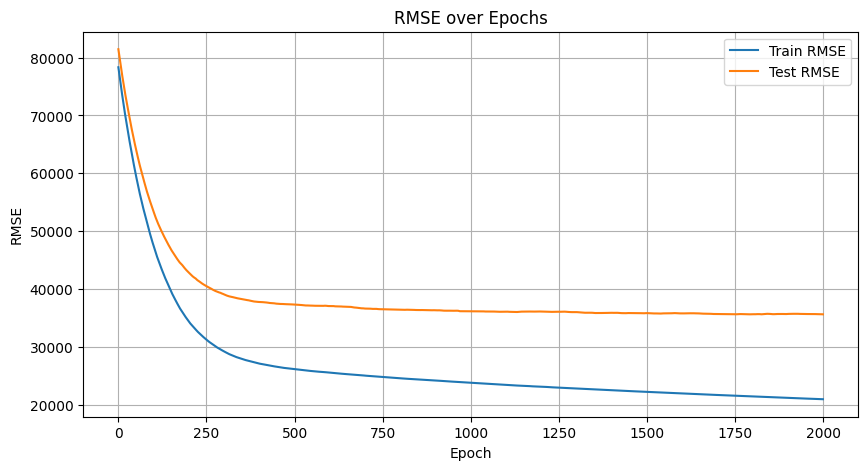

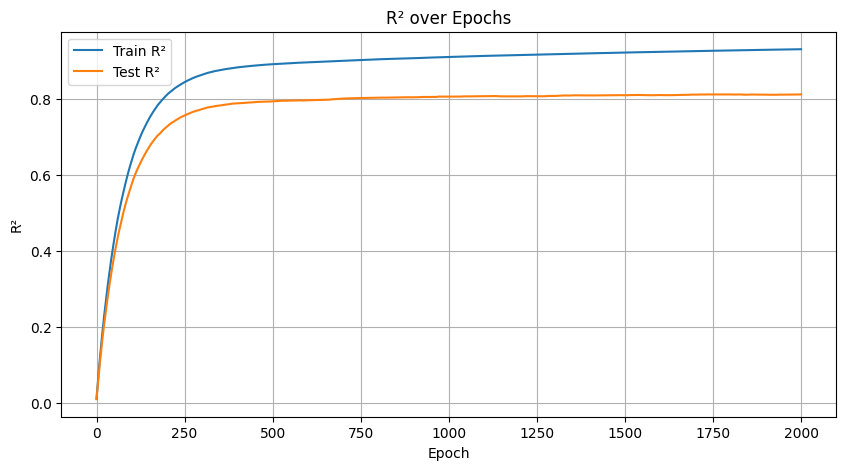

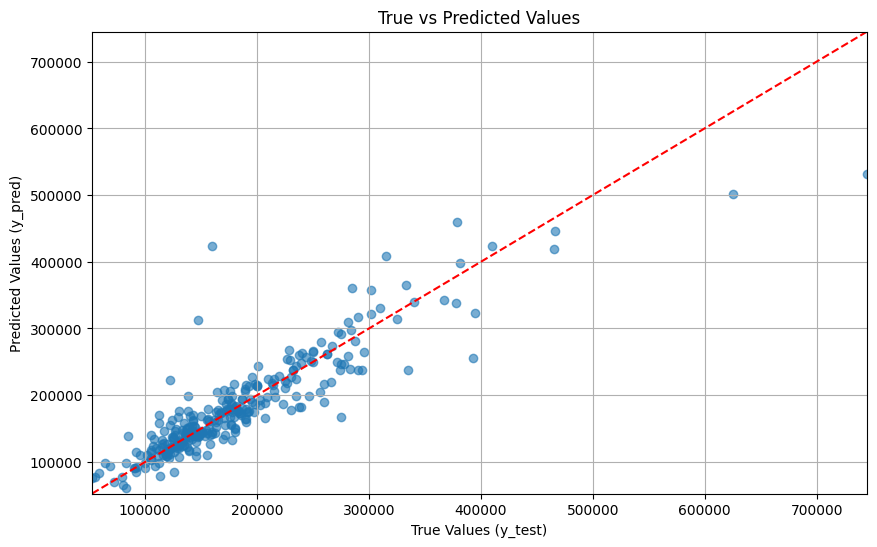

In [4]:
# 模型参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 8,
    'learning_rate': 0.008,
    'max_depth': 15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'lambda_l1': 1  
}

# 初始化存储 RMSE 和 R² 的列表
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []

# 自定义回调函数记录每轮的 RMSE 和 R²
def record_metrics(env):
    # 获取当前轮数
    iteration = env.iteration + 1
    
    # 使用模型进行预测
    y_train_pred = env.model.predict(X_train, num_iteration=iteration)
    y_test_pred = env.model.predict(X_test, num_iteration=iteration)
    
    # 计算 RMSE
    train_rmse.append(mean_squared_error(y_train, y_train_pred, squared=False))
    test_rmse.append(mean_squared_error(y_test, y_test_pred, squared=False))
    
    # 计算 R²
    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))

print('Start training...')
# 训练模型，使用自定义回调函数来记录每轮的 RMSE 和 R²
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[record_metrics]
)

print('Save model...')
# 保存模型
gbm.save_model('lightgbm_model.txt')

print('Start predicting...')
# 在测试集上预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# 计算最终 RMSE 和 R²
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print('The RMSE of prediction is:', rmse)
print('The R² of prediction is:', r2)

print('Feature importances:', list(gbm.feature_importance()))

# 计算训练的轮数
epochs = range(len(train_rmse))

# 绘制 RMSE 曲线
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, test_rmse, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.grid()
plt.show()

# 绘制 R² 曲线
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_r2, label='Train R²')
plt.plot(epochs, test_r2, label='Test R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('R² over Epochs')
plt.legend()
plt.grid()
plt.show()

# 绘制预测值与真实值的点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('True vs Predicted Values')
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()


# 4. 各种参数对模型的影响

为了得到更好的预测结果，我们需要对模型参数进行调优，主要包括以下几个关键参数：

## 4.1 Learning Rate

- **定义**：  
  学习率（Learning Rate）控制模型每次迭代更新权重的步长，值越大模型更新越快。

- **影响**：  
  较大的学习率可能导致模型收敛快，但不稳定，容易错过最优解；较小的学习率可以提高模型的稳定性，找到更优解，但训练速度会变慢。通常，需要结合 `num_boost_round`（迭代次数）进行调优。


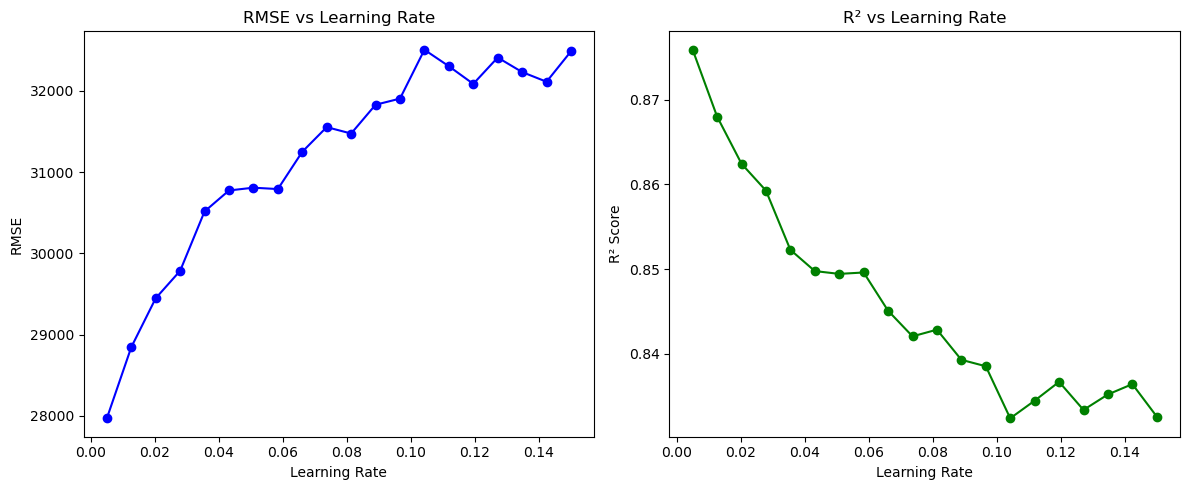

In [15]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Define the range of learning rates for the experiment
learning_rates = np.linspace(0.005, 0.15, num=20)
rmse_results = []
r2_results = []

for lr in learning_rates:
    # Create dataset for LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Specify model parameters for regression with different learning rates
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 25,
        'learning_rate': lr,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    # Train model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval)

    # Predict on the test set
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Calculate RMSE and R2
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Store results
    rmse_results.append(rmse)
    r2_results.append(r2)

# Plotting the results
plt.figure(figsize=(12, 5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(learning_rates, rmse_results, marker='o', linestyle='-', color='blue')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('RMSE vs Learning Rate')

# R² plot
plt.subplot(1, 2, 2)
plt.plot(learning_rates, r2_results, marker='o', linestyle='-', color='green')
plt.xlabel('Learning Rate')
plt.ylabel('R² Score')
plt.title('R² vs Learning Rate')

plt.tight_layout()
plt.show()


## 左图：RMSE vs Learning Rate

- **趋势分析**：  
  随着学习率从 0 增大到 0.14，RMSE 逐渐增加。在低学习率时，RMSE 处于较低水平，而随着学习率增大，RMSE 明显增高，这意味着模型的误差越来越大，性能越来越差。

- **原理**：  
  学习率控制了每一步梯度下降的步长。如果学习率太大，模型会错过最优解，表现为误差增大。通常，较小的学习率可以让模型更平稳地逼近最优解，虽然收敛速度会较慢。

---

## 右图：R² Score vs Learning Rate

- **趋势分析**：  
  随着学习率的增加，R² 逐渐减小。在低学习率下，R² 值接近 0.87，说明模型能够较好地拟合数据；而当学习率增大时，R² 明显下降，这表明模型的解释能力变弱。

- **原理**：  
  较高的学习率会导致模型对训练数据的拟合能力变差，因为步长过大，容易错过损失函数的最小值，使模型在每次更新时越过最优解，导致模型不稳定、性能下降。

---

## 总结：学习率对模型的影响

- 学习率是控制梯度下降步长的参数，较小的学习率有助于模型更好地找到最优解，但可能导致训练速度变慢。相反，较大的学习率会使模型更快地更新参数，但可能导致模型的不稳定，使得误差增大、R² 下降。

- 从图中可以看出，当学习率低于某一阈值时，模型的性能较好，RMSE 较低，R² 较高；但当学习率超过阈值后，模型的性能迅速恶化。因此，为了获得更好的预测效果，应该选择一个适中的学习率。


## 4.2 Number of Leaves

- **定义**：  
  `num_leaves` 控制每棵树的复杂度。`num_leaves` 越大，模型越复杂，能够捕捉更多的数据细节。

- **影响**：  
  较小的 `num_leaves` 可能导致模型欠拟合，而较大的值可能导致模型过拟合，并增加计算成本。通常要在模型复杂度和性能之间找到平衡。


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

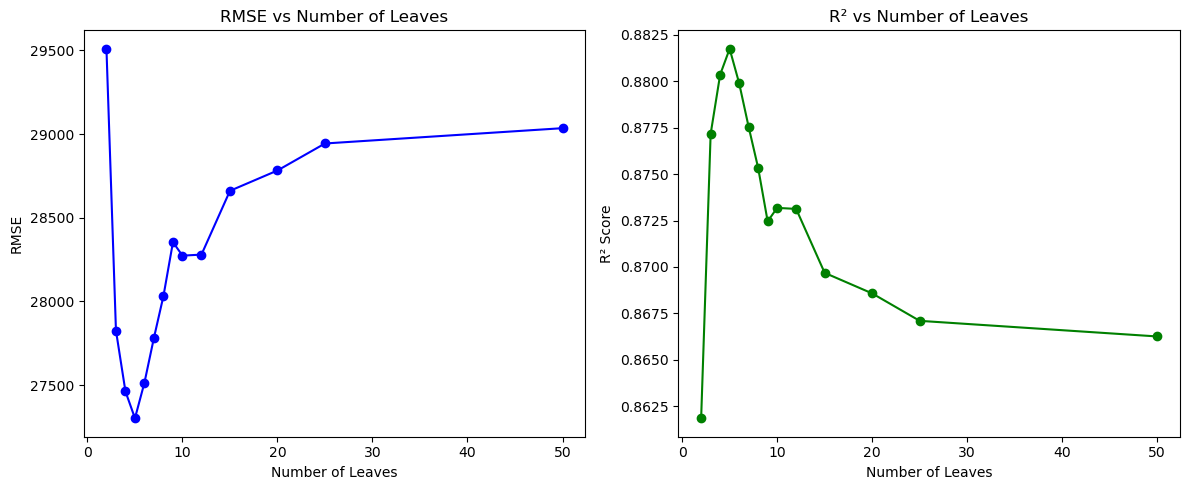

In [11]:
# Define the range of num_leaves to test
num_leaves_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 50]
rmse_results = []
r2_results = []

for num_leaves in num_leaves_values:
    # Create dataset for LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Specify model parameters for regression with different num_leaves
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': num_leaves,
        'learning_rate': 0.015,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    # Train model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval)

    # Predict on the test set
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Calculate RMSE and R²
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Store results
    rmse_results.append(rmse)
    r2_results.append(r2)

# Plotting the results
plt.figure(figsize=(12, 5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(num_leaves_values, rmse_results, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Leaves')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Leaves')

# R² plot
plt.subplot(1, 2, 2)
plt.plot(num_leaves_values, r2_results, marker='o', linestyle='-', color='green')
plt.xlabel('Number of Leaves')
plt.ylabel('R² Score')
plt.title('R² vs Number of Leaves')

plt.tight_layout()
plt.show()


## 左图：RMSE vs Number of Leaves

- **趋势分析**：  
  当叶子节点数量从 0 增加到 10 左右时，RMSE 明显下降，模型预测误差减小，这表明模型的性能在逐渐提升；然而当叶子节点数量继续增大时，RMSE 反而开始增加，表明模型的预测误差增加，性能下降。

- **原理**：  
  在树模型中，叶子节点数量（`num_leaves`）控制了每棵树的复杂度。较少的叶子节点可能导致模型欠拟合，无法充分捕捉数据的特征；但过多的叶子节点会增加模型的复杂度，可能导致过拟合，使模型对训练数据拟合得过于紧密，泛化能力下降。

---

## 右图：R² Score vs Number of Leaves

- **趋势分析**：  
  R² 在叶子节点数量增加到 10 左右时达到峰值，表示模型在此时对数据的解释能力最强；但当叶子节点数量继续增加时，R² 开始下降，说明模型开始过拟合，解释能力减弱。

- **原理**：  
  增加叶子节点数量可以提高模型的复杂度和灵活性，在初始阶段能够更好地拟合数据，R² 提升。然而，当叶子节点数量超过一定阈值后，模型开始过拟合，虽然能够很好地拟合训练数据，但对测试数据的泛化能力减弱，R² 逐渐下降。

---

## 总结：叶子节点数量对模型的影响

1. **初始阶段（0-10 叶子节点）**：  
   模型处于欠拟合状态，增加叶子节点数量有助于捕捉数据中的复杂特征，提升模型性能，降低 RMSE，增加 R²。

2. **超过阈值后（>10 叶子节点）**：  
   模型开始变得过于复杂，出现过拟合现象。过多的叶子节点导致模型对训练数据的过度拟合，导致测试误差（RMSE）增加，R² 下降，模型泛化能力减弱。


## 4.3 Max Depth

- **定义**：  
  `max_depth` 限制每棵树的最大深度，从而控制模型的复杂度。

- **影响**：  
  较浅的树可能无法捕捉到复杂的特征关系，导致欠拟合；而较深的树会使模型更复杂，容易过拟合并增加计算成本。设置合适的 `max_depth` 可以有效地控制模型的拟合能力。


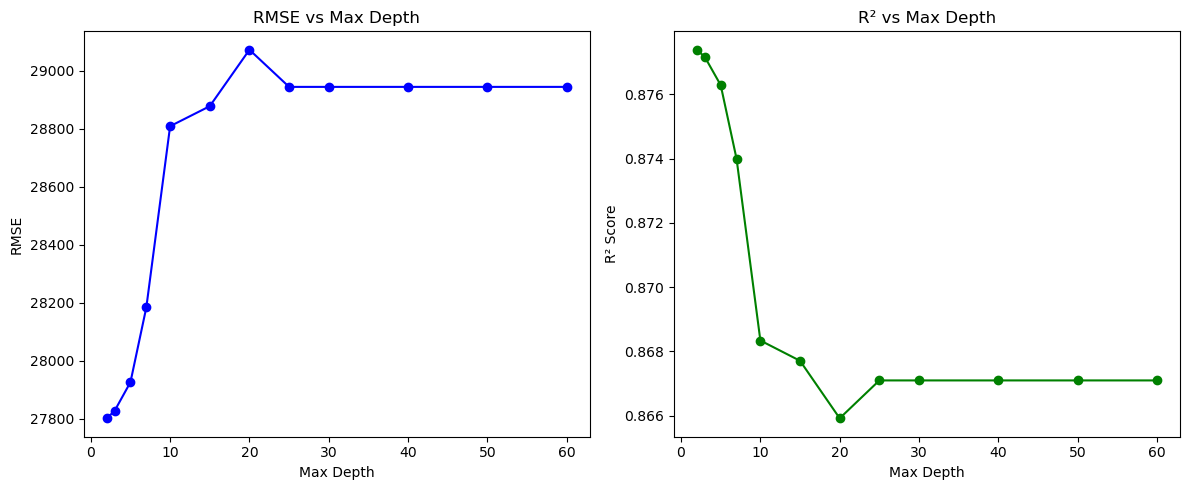

In [16]:
# Define the range of max_depth values for the experiment
max_depth_values = [2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60]
rmse_results = []
r2_results = []

for max_depth in max_depth_values:
    # Create dataset for LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Specify model parameters for regression with different max_depth
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 25,
        'learning_rate': 0.015,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'max_depth': max_depth,  # Tree depth parameter
        'verbose': -1
    }

    # Train model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval)

    # Predict on the test set
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Calculate RMSE and R2
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Store results
    rmse_results.append(rmse)
    r2_results.append(r2)

# Plotting the results
plt.figure(figsize=(12, 5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(max_depth_values, rmse_results, marker='o', linestyle='-', color='blue')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('RMSE vs Max Depth')

# R² plot
plt.subplot(1, 2, 2)
plt.plot(max_depth_values, r2_results, marker='o', linestyle='-', color='green')
plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('R² vs Max Depth')

plt.tight_layout()
plt.show()


## 左图：RMSE vs Max Depth

- **趋势分析**：  
  - 在 `max_depth` 较小（如 0 到 10）时，RMSE 逐渐降低，表明模型性能提升，误差减小。
  - 在 `max_depth` 达到 20 之后，RMSE 显著增加，表示模型开始变得不稳定，误差增加；随后，RMSE 保持相对稳定，表明更大的树深度未能进一步降低误差。

- **原理**：  
  较小的 `max_depth` 会导致模型欠拟合，无法充分捕捉数据中的特征，因此误差较大；而过大的树深度可能导致模型过拟合，增加模型复杂度，反而增加误差。

---

## 右图：R² vs Max Depth

- **趋势分析**：  
  - 随着 `max_depth` 增加到 10 左右，R² 得到提升，达到最高值（约为 0.876），模型能够较好地解释数据中的方差。
  - 当 `max_depth` 超过 10 后，R² 迅速下降并趋于稳定，说明模型的解释能力减弱，模型开始过拟合，无法泛化到测试数据。

- **原理**：  
  增加树的深度能够提高模型拟合数据的能力，在初始阶段可以显著提升 R²，但超过某个深度阈值后，模型变得过于复杂，对训练数据过度拟合，解释能力反而下降。

---

## 总结：最大深度对模型的影响

1. **初始阶段（较小的 Max Depth）**：  
   当树的最大深度较小（0-10）时，模型处于欠拟合状态。随着深度增加，模型能够更好地拟合数据，RMSE 下降，R² 上升。

2. **过拟合阶段（Max Depth > 10）**：  
   当树的深度继续增加到一定阈值（如 20 左右），模型开始过拟合，导致 RMSE 增加，R² 降低。

3. **模型的选择**：  
   需要选择一个合适的最大深度来平衡模型的拟合能力和泛化能力。通过交叉验证等方法，可以找到最佳的树深度，确保模型在复杂度和性能之间保持平衡。


## 4.4 L1 正则化值

- **定义**：  
  L1 正则化引入一个惩罚项，控制模型的稀疏性，鼓励权重趋近于零，从而降低模型复杂度，防止过拟合。

- **影响**：  
  较大的 `lambda_l1` 值会增加正则化强度，促使模型更简单，但可能导致欠拟合；较小的值则更容易使模型拟合训练数据，但可能导致过拟合。选择合适的 `lambda_l1` 可以在防止过拟合和保持模型预测能力之间取得平衡。


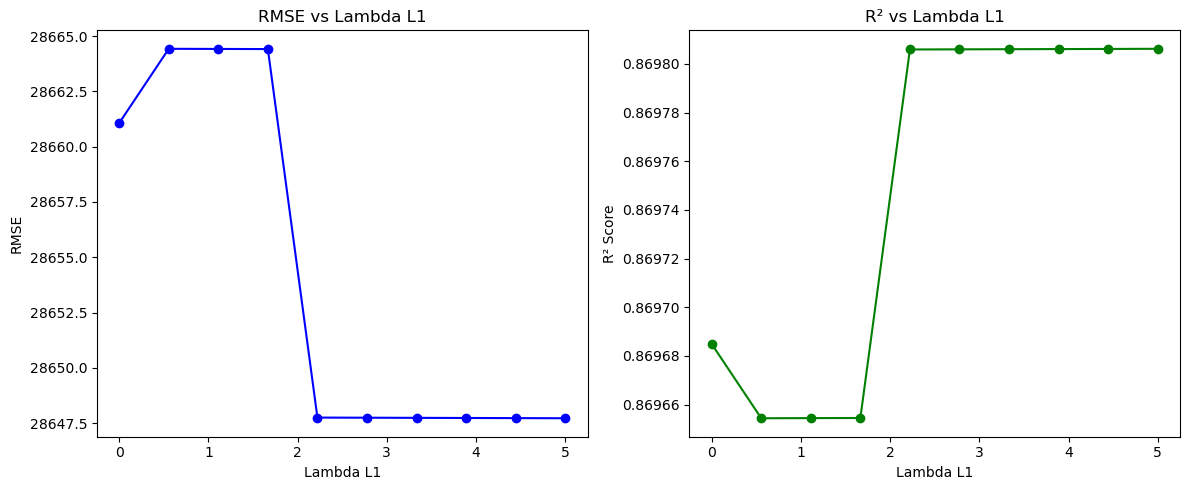

In [14]:
# Define the range of L1 regularization parameters to test
lambda_l1_values = np.linspace(0, 5, num=10)
rmse_results = []
r2_results = []

for lambda_l1 in lambda_l1_values:
    # Create dataset for LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Specify model parameters for regression with L1 regularization
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 15,
        'learning_rate': 0.015,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l1': lambda_l1  # L1 regularization parameter
    }

    # Train model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval)

    # Predict on the test set
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Calculate RMSE and R²
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Store results
    rmse_results.append(rmse)
    r2_results.append(r2)

# Plotting the results
plt.figure(figsize=(12, 5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(lambda_l1_values, rmse_results, marker='o', linestyle='-', color='blue')
plt.xlabel('Lambda L1')
plt.ylabel('RMSE')
plt.title('RMSE vs Lambda L1')

# R² plot
plt.subplot(1, 2, 2)
plt.plot(lambda_l1_values, r2_results, marker='o', linestyle='-', color='green')
plt.xlabel('Lambda L1')
plt.ylabel('R² Score')
plt.title('R² vs Lambda L1')

plt.tight_layout()
plt.show()


## 左图：RMSE vs Lambda L1

- **趋势分析**：  
  - 当 `Lambda L1` 从 0 增加到 2 时，RMSE 有一个非常明显的下降，这意味着模型的预测误差大幅减少，性能提升。
  - 当 `Lambda L1` 超过 2 后，RMSE 保持稳定，不再显著下降，这表明在超过某个阈值后，L1 正则化强度对模型性能不再有显著影响。

- **原理**：  
  L1 正则化引入了一种惩罚项，鼓励模型参数稀疏化，防止过拟合。在正则化强度较小时，模型参数没有得到足够的约束，因此 RMSE 较高；当正则化强度增加到一定程度时，模型参数趋于稀疏，过拟合得到缓解，RMSE 下降。

---

## 右图：R² vs Lambda L1

- **趋势分析**：  
  - 当 `Lambda L1` 增加到 2 之前，R² 下降，模型的解释能力减弱。这可能是由于 L1 正则化惩罚项开始对模型参数进行约束，导致模型对数据的解释能力下降。
  - 然而，当 `Lambda L1` 超过 2 时，R² 快速上升并保持稳定，说明模型的解释能力得到了增强并稳定在一个较高的水平。

- **原理**：  
  L1 正则化的引入使模型参数变得稀疏，避免了过度拟合；随着正则化强度的增加，模型参数的稀疏性得到保证，因此 R² 得到了提升，模型的解释能力增强。

---

## 总结：L1 正则化对模型的影响

1. **初始阶段（较小的 Lambda L1）**：  
   当 `Lambda L1` 较小时，模型未受到正则化的足够约束，可能出现过拟合现象，导致 RMSE 较高，R² 较低。

2. **阈值阶段（Lambda L1 约 2）**：  
   当正则化强度增加到某个临界值时，模型的参数稀疏性得以保证，预测误差显著降低，解释能力得到增强。

3. **稳定阶段（较大的 Lambda L1）**：  
   当 `Lambda L1` 继续增加时，模型性能趋于稳定，RMSE 和 R² 均保持平稳状态，这说明模型参数已经充分稀疏化，进一步增加正则化强度对模型性能不再有显著影响。



## 5. 总结

通过使用 LightGBM，我们可以高效地进行房价预测任务。模型的性能受多种参数的影响，如学习率、树的深度、叶子节点数量、正则化参数等。在实际应用中，为了提升模型的预测性能，需要针对这些参数进行调优。